# Julia-Perple_X interface demo

This notebook runs the <a href="https://github.com/brenhinkeller/StatGeochem.jl" target="_blank">StatGeochem.jl</a> package, which implements an interface for interacting with <a href="https://www.perplex.ethz.ch" target="_blank">Perple_X</a> from the <a href="https://julialang.org" target="_blank">Julia programming language</a>, including from Jupyter notebooks such as this.

StatGeochem.jl also includes some of the codes and utilities used in <a href="https://doi.org/10.1038/nature11024" target="_blank">Keller & Schoene 2012</a>, <a href="https://doi.org/10.1038/nature14584" target="_blank">Keller et al. 2015</a> and <a href="https://doi.org/10.1016/j.epsl.2017.10.031" target="_blank">Keller & Schoene 2018</a>.

<a href="https://mybinder.org/v2/gh/brenhinkeller/StatGeochem.jl/main?filepath=examples%2FPerplexExamples.ipynb" target="_blank"><img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***
### Load required Julia packages

In [1]:
## --- Load the StatGeochem package
using StatGeochem
using Plots

In [3]:
## Specify scratch directory

# Absolute paths to perplex resources
scratchdir = "./scratch/" # Location of directory to store output files


"./scratch/"

### Pre StatGeochem v0.8:Try to download and install Perple_X

In [4]:

# perplexdir = joinpath(resourcepath,"perplex-stable")

# # Attempt to install perplex, if not already extant
# if !isfile(joinpath(perplexdir,"vertex"))
#     # Make sure resourcepath exists
#     run(`mkdir -p $resourcepath`)

#     # Try to compile PerpleX from source; if that fails, try to download linux binaries
#     try
#         # Check if there is a fortran compiler
#         run(`gfortran -v`)

#         # Download Perplex v6.8.7 -- known to work with interface used here
#         file = download("https://storage.googleapis.com/statgeochem/perplex-6.8.7-source.zip", joinpath(resourcepath,"perplex-stable.zip"))

#         # # For a more updated perplex version, you might also try
#         # file = download("https://petrol.natur.cuni.cz/~ondro/perplex-sources-stable.zip", joinpath(resourcepath,"perplex-stable.zip"))

#         run(`unzip -u $file -d $resourcepath`) # Extract
#         system("cd $perplexdir; make") # Compile
#     catch
#         @warn "Failed to compile from source, trying precompiled linux binaries instead"
#         run(`mkdir -p $perplexdir`)
#         file = download("https://petrol.natur.cuni.cz/~ondro/Perple_X_6.8.7_Linux_64_gfortran.tar.gz","perplex-6.8.7-linux.tar.gz")
#         run(`tar -xzf $file -C $perplexdir`)
#     end
# end

### Configure Perple_X options

In [4]:
## --- # # # # # # # # # # # # # Initial composition # # # # # # # # # # # # # #

## McDonough Pyrolite
#elements =    [ "SIO2", "TIO2", "AL2O3",  "FEO",  "MNO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [45.1242, 0.2005, 4.4623, 8.0723, 0.1354, 37.9043, 3.5598, 0.3610, 0.0291, 0.1511, 0.0440,]

## Kelemen (2014) primitive continental basalt. H2O and CO2 are guesses
#elements =    [ "SIO2", "TIO2", "AL2O3",  "FEO",  "MNO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [50.0956, 0.9564, 15.3224, 8.5103, 0.1659, 9.2520, 9.6912, 2.5472, 0.8588, 2.0000, 0.6000,]

# Kelemen (2014) primitive continental basalt excluding Mn and Ti since most melt models can"t handle them..
elements =    [ "SIO2", "AL2O3",  "FEO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
composition = [50.0956, 15.3224, 8.5103, 9.2520, 9.6912, 2.5472, 0.8588, 2.0000, 0.6000,]

## Average Archean basalt (EarthChem data)
#elements =    [ "SIO2", "TIO2", "AL2O3",   "FEO",  "MNO",   "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [49.2054, 0.8401, 12.0551, 11.4018, 0.2198, 12.3997, 9.3113, 1.6549, 0.4630, 1.8935, 0.5555,]

9-element Vector{Float64}:
 50.0956
 15.3224
  8.5103
  9.252
  9.6912
  2.5472
  0.8588
  2.0
  0.6

In [5]:
## --- # # # # # # # # # # # Some solution model options # # # # # # # # # # # #

# Emphasis on phases from Green (2016) -- developed for metabasites, includes what is probably the best (and most expensive) amphibole model. Use with hp11ver.dat
G_solution_phases = "Augite(G)\nOpx(JH)\ncAmph(G)\noAmph(DP)\nO(JH)\nSp(JH)\nGrt(JH)\nfeldspar_B\nMica(W)\nBio(TCC)\nChl(W)\nCtd(W)\nCrd(W)\nSa(WP)\nSt(W)\nIlm(WPH)\nAtg(PN)\nT\nB\nF\nDo(HP)\nScap\nChum\nNeph(FB)\n"
G_excludes ="ged\nfanth\ngl\nilm\nilm_nol\n"

# Emphasis on phases from White (2014) -- developed for metapelites. Use with hp11ver.dat (though can apparenty run with hp02ver.dat without crashing)
W_solution_phases = "Omph(HP)\nOpx(W)\ncAmph(DP)\noAmph(DP)\nO(JH)\nSp(JH)\nGt(W)\nfeldspar_B\nMica(W)\nBi(W)\nChl(W)\nCtd(W)\nCrd(W)\nSa(WP)\nSt(W) \nIlm(WPH)\nAtg(PN)\nT\nB\nF\nDo(HP)\nScap\nChum\nPu(M)\n"
W_excludes = "andr\nts\nparg\ngl\nged\nfanth\n"

# Emphasis on phases from Jennings and Holland (2015) -- developed for mantle melting. Use with hp11ver.dat
JH_solution_phases = "Cpx(JH)\nOpx(JH)\ncAmph(DP)\noAmph(DP)\nO(JH)\nSp(JH)\nGrt(JH)\nfeldspar_B\nMica(W)\nBio(TCC)\nChl(W)\nCtd(W)\nCrd(W)\nSa(WP)\nSt(W)\nIlm(WPH)\nAtg(PN)\nT\nB\nF\nDo(HP)\nScap\nChum\nNeph(FB)\n"
JH_excludes = "ts\nparg\ngl\nged\nfanth\n"

# Emphasis on phases from Holland and Powell -- all phases can be used with hp02ver.dat.
# HP_solution_phases = "Omph(HP)\nOpx(HP)\nGlTrTsPg\nAnth\nO(HP)\nSp(HP)\nGt(HP)\nfeldspar_B\nMica(CF)\nBio(TCC)\nChl(HP)\nCtd(HP)\nSapp(HP)\nSt(HP)\nIlHm(A)\nDo(HP)\nT\nB\nF\n"
HP_solution_phases = "Omph(HP)\nOpx(HP)\nAnth\nO(HP)\nSp(HP)\nGt(HP)\nfeldspar_B\nMica(CF)\nBio(TCC)\nCtd(HP)\nSt(HP)\nIlHm(A)\nDo(HP)\nT\nB\nF\n"
HP_excludes = ""

""

### Run Perple_X

In [6]:
## --- # # # # # # # # # # # # # Isobaric example # # # # # # # # # # # # # # # #

    # Input parameters
    P = 1000 # Pressure, bar
    T_range = (0+273.15, 1500+273.15) # Temperature range, Kelvin
    # melt_model = "melt(G)"
    melt_model = "melt(HP)"


    # Configure (run build and vertex)
    # @time perplex_configure_isobar(scratchdir, composition, elements,
    #     P, T_range, dataset="hp11ver.dat", npoints=100, excludes=G_excludes,
    #     solution_phases=melt_model*"\n"*G_solution_phases)

    @time perplex_configure_isobar(scratchdir, composition, elements, P, T_range,
        dataset="hp02ver.dat",
        npoints=100,
        excludes=HP_excludes,
        solution_phases=melt_model*"\n"*HP_solution_phases
    )
    
## --- Query all properties at a single temperature -- results returned as text

    T = 850+273.15
    data_isobaric = perplex_query_point(scratchdir, T) |> print

  4.508019 seconds (190.51 k allocations: 10.170 MiB, 0.96% compilation time)

----------------------------------------

Stable phases at:
                             T(K)     =  1123.15    
                             P(bar)   =  1000.00    

Phase Compositions (weight percentages):
                   wt %      vol %     mol %     mol        SIO2     AL2O3    FEO      MGO      CAO      NA2O     K2O      H2O      CO2  
 Omph(HP)          18.67     12.84     15.50    0.830E-01   51.385    4.742    6.005   12.779   24.936    0.153    0.000    0.000    0.000
 Opx(HP)           13.33      8.84     11.10    0.594E-01   53.659    0.926   21.460   23.955    0.000    0.000    0.000    0.000    0.000
 O(HP)             13.16      8.18     14.60    0.782E-01   36.114    0.000   35.162   28.724    0.000    0.000    0.000    0.000    0.000
 feldspar_B        46.41     39.60     31.62    0.169       54.675   28.846    0.000    0.000   11.041    5.128    0.310    0.000    0.000
 feldspar_B        

In [7]:
## --- Query the full isobar -- results returned as dict

bulk = perplex_query_system(scratchdir)             # Get system data for all temperatures. Set include_fluid = "n" to get solid+melt only
modes = perplex_query_modes(scratchdir)             # || phase modes
melt = perplex_query_phase(scratchdir, melt_model)  # || melt data

# Melt wt.% seems to be slightly inaccurate; use values from modes instead
melt["wt_pct"] = modes[melt_model]

# Create dictionary to hold solid composition and fill it using what we know from system and melt
solid = Dict()
solid["wt_pct"] = 100 .- melt["wt_pct"]
for e in ["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"]
    solid[e] = (bulk[e] - (melt[e] .* melt["wt_pct"]/100)) ./ (solid["wt_pct"]/100)
end
renormalize!(solid,["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"],total=100)

┌ Warning: Perplex seems to be reporting mole fractions instead of weight percentages
└ @ StatGeochem /Users/jannitta/.julia/packages/StatGeochem/RYqBi/src/resources/Perplex.jl:754


Dict{Any, Any} with 8 entries:
  "SIO2"   => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  50.2584, 50…
  "CAO"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  25.4748, 25…
  "K2O"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  -1.85711e-5…
  "AL2O3"  => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  7.74432, 7.…
  "wt_pct" => [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1…
  "FEO"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  2.7228, 2.7…
  "MGO"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  13.7518, 13…
  "NA2O"   => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.0478889, …

#### Plot results

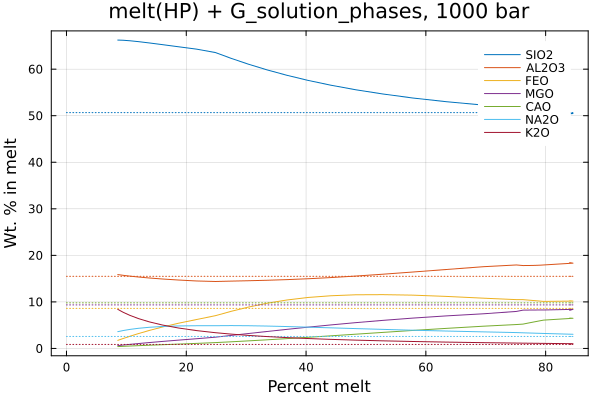

In [8]:
## --- Plot melt composition as a function of melt percent

h = plot(xlabel="Percent melt", ylabel="Wt. % in melt", title="$melt_model + G_solution_phases, $P bar")
i = 0
for e in ["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"]
    plot!(h, melt["wt_pct"], melt[e], label=e, color=lines[global i += 1])
    plot!(h, melt["wt_pct"], bulk[e], label="", color=lines[i], linestyle=:dot)
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"MeltComposition.pdf")
display(h)

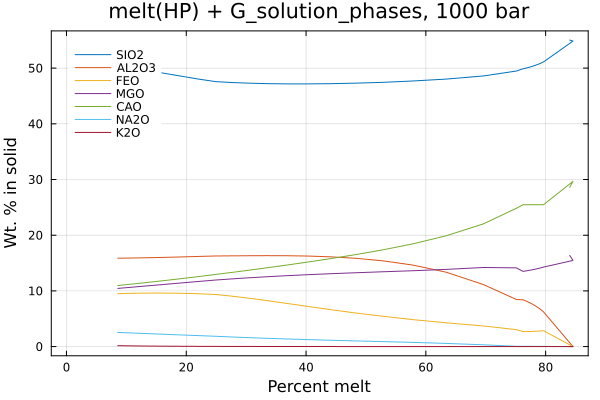

In [9]:
## --- Plot solid composition as a function of melt percent

h = plot(xlabel="Percent melt", ylabel="Wt. % in solid", title="$melt_model + G_solution_phases, $P bar")
i = 0
for e in ["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"]
    plot!(h, melt["wt_pct"], solid[e], label=e, color=lines[global i +=1])
end
plot!(h,fg_color_legend=:white, framestyle=:box, legend=:topleft)
# savefig(h,"SolidComposition.pdf")
display(h)

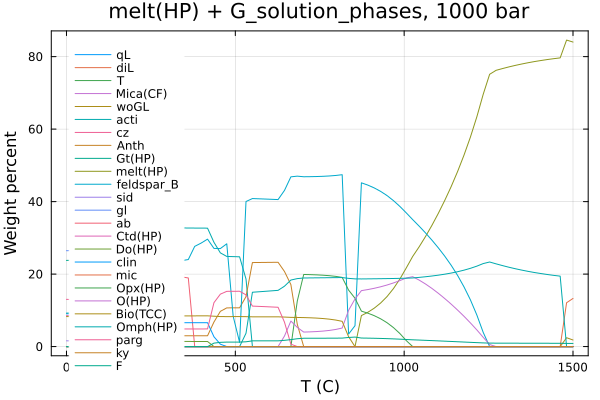

In [10]:
## --- Plot modes of all phases as a function of temperature

h = plot(xlabel="T (C)", ylabel="Weight percent", title="$melt_model + G_solution_phases, $P bar")
# for m in modes["elements"][3:end]
for m in keys(modes)
    if m != "system" && m != "T(K)"
        plot!(h, modes["T(K)"] .- 273.15, modes[m], label=m)
    end
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"PhaseModes.pdf")
display(h)

In [11]:
## --- # # # # # # # # # # # Geothermal gradient example # # # # # # # # # # # #

# Input parameters
P_range = (280, 28000) # Pressure range to explore, bar (roughly 1-100 km depth)
T_surf = 273.15 # Temperature of surface (K)
geotherm = 0.1 # Geothermal gradient of 0.1 K/bar == about 28.4 K/km
melt_model = ""

# Configure (run build and vertex)
@time perplex_configure_geotherm(scratchdir, composition, elements,
    P_range, T_surf, geotherm, dataset="hp02ver.dat", excludes=HP_excludes,
    solution_phases=HP_solution_phases, npoints=200, index=2, mode_basis = "wt")

# # Alternative configuration, using hpha02ver.dat
# @time perplex_configure_geotherm(perplexdir, scratchdir, composition, elements,
#     P_range, T_surf, geotherm, dataset="hpha02ver.dat", excludes="qGL\n"*HP_excludes,
#     solution_phases=HP_solution_phases, npoints=200, index=2)

# # Alternative configuration, using hpha02ver.dat and new phases for metapelites
# @time perplex_configure_geotherm(perplexdir, scratchdir, composition, elements,
#     P_range, T_surf, geotherm, dataset="hpha02ver.dat", excludes="qGL\n"*W_excludes,
#     solution_phases=W_solution_phases, npoints=200, index=2)

Built problem definition
  1.520845 seconds (66.01 k allocations: 3.552 MiB, 2.85% compilation time)


0

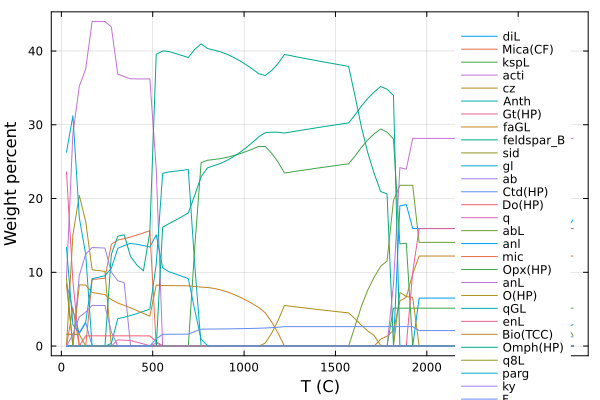

In [12]:
## --- Plot modes of all phases as a function of temperature

# Get phase modes
modes = perplex_query_modes( scratchdir, index=2)

h = plot(xlabel="T (C)", ylabel="Weight percent")
 # for m in modes["elements"][3:end]
 for m in keys(modes)
    if m != "system" && m != "T(K)"
        plot!(h, modes["T(K)"] .- 273.15, modes[m], label=m)
    end
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"GeothermPhaseModes.pdf")
display(h)

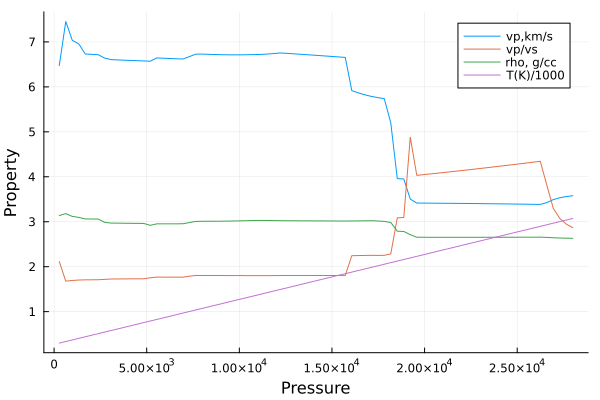

In [13]:
## --- Plot seismic properties

# Query seismic properties along the whole profile
seismic = perplex_query_seismic(scratchdir, index=2)
seismic["vp/vs"][seismic["vp/vs"] .> 100] .= NaN # Exclude cases where vs drops to zero

h = plot(xlabel="Pressure", ylabel="Property")
plot!(h,seismic["P(bar)"],seismic["vp,km/s"], label="vp,km/s")
plot!(h,seismic["P(bar)"],seismic["vp/vs"], label="vp/vs")
plot!(h,seismic["P(bar)"],seismic["rho,kg/m3"]/1000, label="rho, g/cc")
plot!(h,seismic["P(bar)"],seismic["T(K)"]/1000, label="T(K)/1000")
# savefig(h,"GeothermSeismicProperties.pdf")
display(h)

In [14]:
## --- Query all properties at a single pressure

P = 10000
data_geotherm = perplex_query_point(scratchdir, P, index=2) |> print


----------------------------------------

Stable phases at:
                             P(bar)   =  10000.0    
                             T(K)     =  1273.15    

Phase Compositions (weight percentages):
                   wt %      vol %     mol %     mol        SIO2     AL2O3    FEO      MGO      CAO      NA2O     K2O      H2O      CO2  
 Omph(HP)          26.68     23.00     23.71    0.119       48.501   10.666    6.686    9.611   23.719    0.817    0.000    0.000    0.000
 Opx(HP)           26.28     21.78     23.26    0.116       51.156    4.481   22.889   21.475    0.000    0.000    0.000    0.000    0.000
 feldspar_B        38.31     41.31     28.10    0.140       57.136   27.146    0.000    0.000    9.063    6.155    0.500    0.000    0.000
 Bio(TCC)           6.36      6.25      2.84    0.142E-01   37.600   16.873   12.721   18.086    0.000    0.000   10.648    4.073    0.000
 F                  2.37      7.66     22.09    0.110        0.000    0.000    0.000    0.000    

Built problem definition
  0.687093 seconds (8.52 k allocations: 481.320 KiB, 0.75% compilation time)
Built problem definition
  0.982104 seconds (285 allocations: 22.461 KiB)
Built problem definition
  0.883072 seconds (281 allocations: 21.453 KiB)
Built problem definition
  1.114250 seconds (284 allocations: 22.695 KiB)
Built problem definition
  1.482607 seconds (281 allocations: 21.453 KiB)


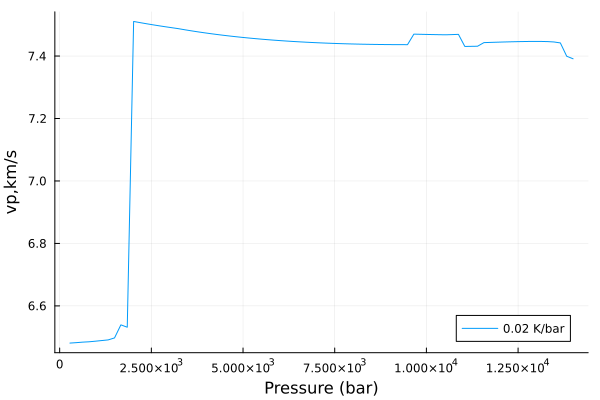

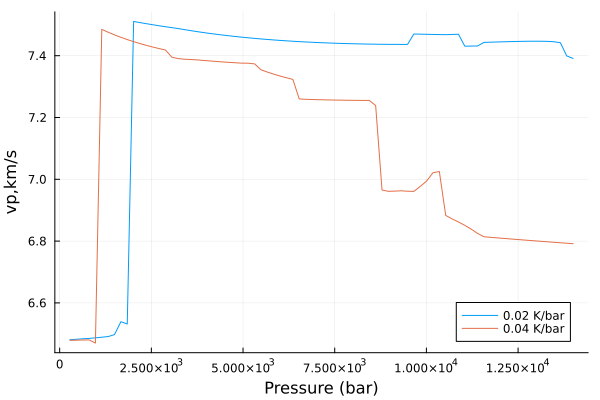

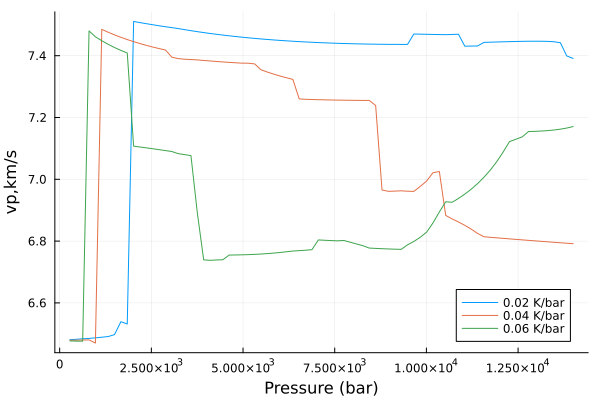

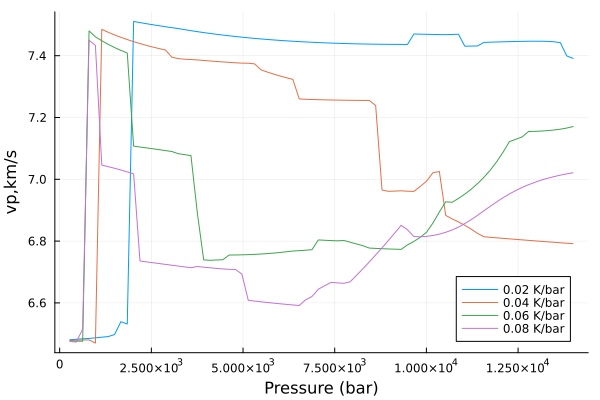

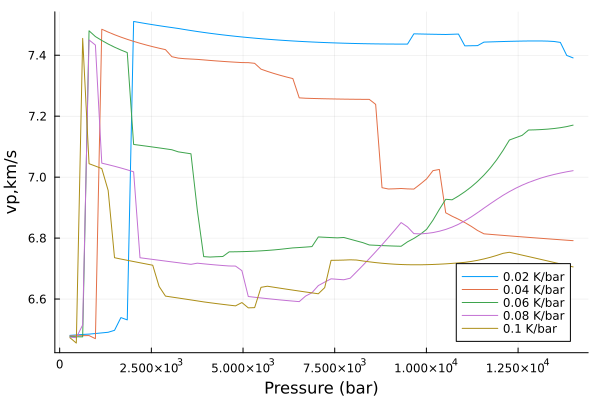

In [15]:
## --- Compare seismic properties for several different geotherms, as a function of Pressure

    # Input parameters
    P_range = (280, 14000) # Pressure range to explore, bar (roughly 1-50 km depth)
    T_surf = 273.15 # Temperature of surface (K)
    dataset="hp02ver.dat"
    yelem = "vp,km/s"
    # yelem = "rho,kg/m3"

    h = plot(xlabel="Pressure (bar)", ylabel=yelem)
    for i=1:5
        geotherm = i/50
        # Configure (run build and vertex)
        @time perplex_configure_geotherm(scratchdir, composition, elements,
            P_range, T_surf, geotherm, dataset=dataset, excludes=HP_excludes,
            solution_phases=HP_solution_phases, npoints=200, index=10+i)
        # Query perplex results
        seismic = perplex_query_seismic(scratchdir, index=10+i)
        # Plot results
        plot!(h,seismic["P(bar)"],seismic[yelem], label="$geotherm K/bar")
        display(h)
    end

Built problem definition
  0.738843 seconds (281 allocations: 21.414 KiB)
Built problem definition
  1.622581 seconds (284 allocations: 21.914 KiB)
Built problem definition
  0.983951 seconds (281 allocations: 21.453 KiB)
Built problem definition
  1.279877 seconds (283 allocations: 22.414 KiB)
Built problem definition
  1.612727 seconds (282 allocations: 21.734 KiB)


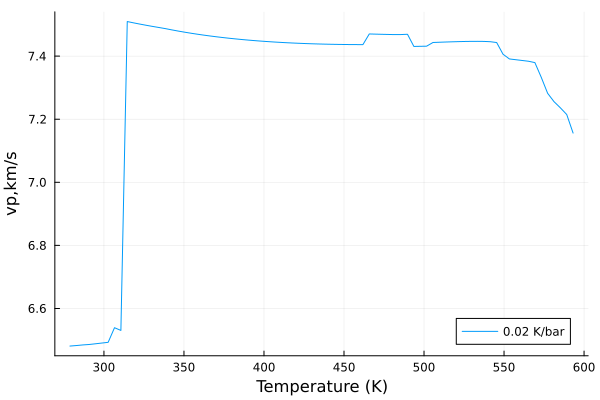

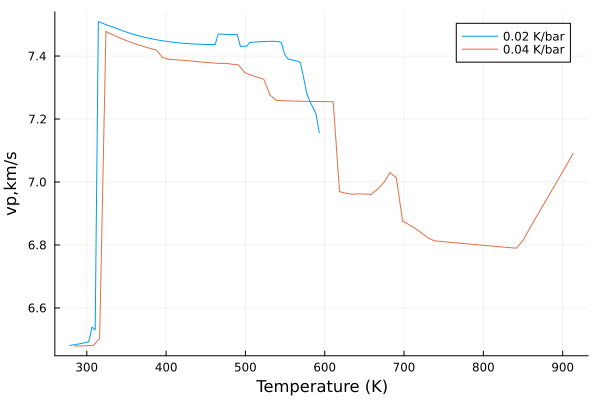

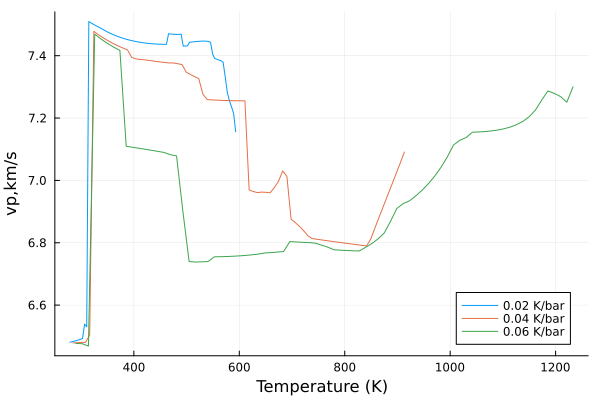

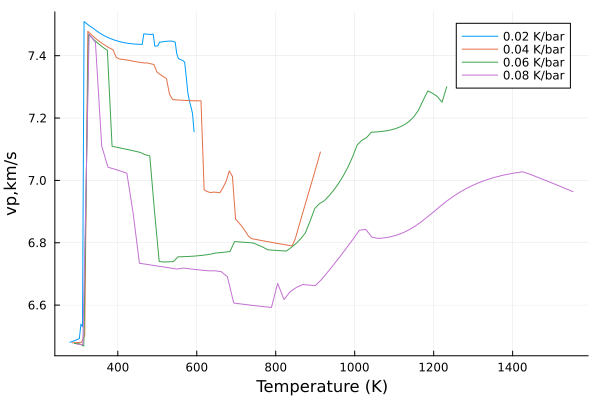

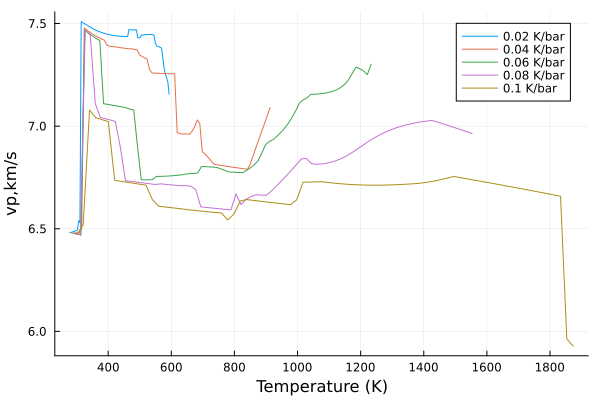

In [16]:
## --- Compare seismic properties for several different geotherms, as a function of temperature

    # Input parameters
    P_range = (280, 16000) # Pressure range to explore, bar (roughly 1-60 km depth)
    T_surf = 273.15 # Temperature of surface (K)
    dataset="hp02ver.dat"
    yelem = "vp,km/s"
    # yelem = "rho,kg/m3"

    h = plot(xlabel="Temperature (K)", ylabel=yelem)
    for i=1:5
        geotherm = i/50
        # Configure (run build and vertex)
        @time perplex_configure_geotherm(scratchdir, composition, elements,
            P_range, T_surf, geotherm, dataset=dataset, excludes=HP_excludes,
            solution_phases=HP_solution_phases, npoints=200, index=10+i)
        # Query perplex results
        seismic = perplex_query_seismic(scratchdir, index=10+i)
        # Plot results
        plot!(h,seismic["T(K)"],seismic[yelem], label="$geotherm K/bar")
        display(h)
    end

In [17]:
## --- Build a pseudosection

    # Input parameters
    mingeotherm = 0.009 # Geothermal gradient, K/bar. For reference, 0.1 K/bar ≈ 28.4 K/km
    max_lith_T = 1300 # Maximum temperature of the TBL lithosphere (no point calculating beyond that)
    P_range = (280, (max_lith_T-273.15)/mingeotherm) # Pressure range to explore, bar (roughly 1-100 km depth)
    T_range = (273.15, max_lith_T) # Temperature range to explore, K
    melt_model = ""

    # Configure (run build and vertex)
    @time perplex_configure_pseudosection(scratchdir, composition,
        elements, P_range, T_range, dataset="hp02ver.dat", excludes=HP_excludes,
        solution_phases=melt_model*HP_solution_phases, index=3, xnodes=100, ynodes=100)

453.344861 seconds (55.78 k allocations: 2.954 MiB, 0.01% compilation time)


0

┌ Info: Duplicate key Gt(HP) found, summing
└ @ StatGeochemBase /Users/jannitta/.julia/packages/StatGeochemBase/ZsiH8/src/Import.jl:595
┌ Info: Duplicate key Mica(CF) found, summing
└ @ StatGeochemBase /Users/jannitta/.julia/packages/StatGeochemBase/ZsiH8/src/Import.jl:595


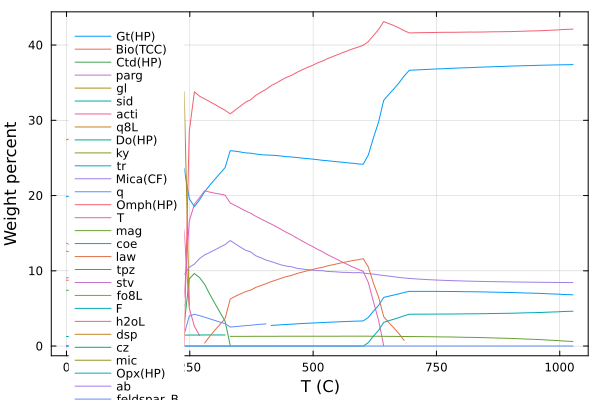

  0.687641 seconds (205.29 k allocations: 10.509 MiB, 13.79% compilation time)


┌ Info: Duplicate key Omph(HP) found, summing
└ @ StatGeochemBase /Users/jannitta/.julia/packages/StatGeochemBase/ZsiH8/src/Import.jl:595
┌ Info: Duplicate key F found, summing
└ @ StatGeochemBase /Users/jannitta/.julia/packages/StatGeochemBase/ZsiH8/src/Import.jl:595
┌ Info: Duplicate key feldspar_B found, summing
└ @ StatGeochemBase /Users/jannitta/.julia/packages/StatGeochemBase/ZsiH8/src/Import.jl:595


In [18]:
## --- Query modes from a pseudosection

geotherm = 0.015 # Geothermal gradient, K/bar. For reference, 0.1 K/bar ≈ 28.4 K/km
@time modes = perplex_query_modes(scratchdir, (280, (max_lith_T-273.15)/geotherm), T_range, index=3, npoints=100)

h = plot(xlabel="T (C)", ylabel="Weight percent")
for m in modes["elements"][3:end]
    plot!(h, modes["T(K)"] .- 273.15, modes[m], label=m)
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"GeothermPhaseModesPseudosection.pdf")
display(h)

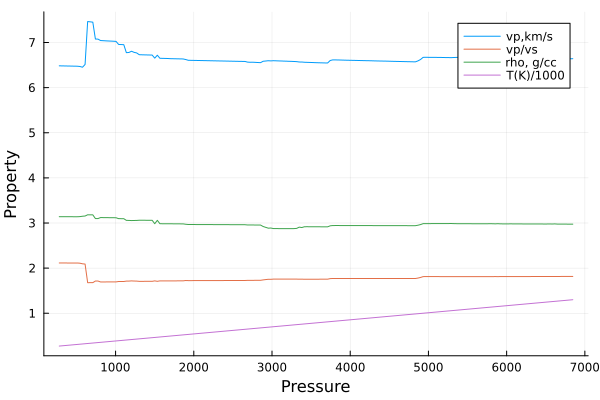

  0.611206 seconds (38.06 k allocations: 2.020 MiB, 2.59% compilation time)


In [19]:
## --- Query seismic properties from a pseudosection

geotherm = 0.15 # Geothermal gradient, K/bar. For reference, 0.1 K/bar ≈ 28.4 K/km
@time seismic = perplex_query_seismic(scratchdir, (280, (max_lith_T-273.15)/geotherm), T_range, index=3, npoints=200)

h = plot(xlabel="Pressure", ylabel="Property")
plot!(h,seismic["P(bar)"],seismic["vp,km/s"], label="vp,km/s")
plot!(h,seismic["P(bar)"],seismic["vp/vs"], label="vp/vs")
plot!(h,seismic["P(bar)"],seismic["rho,kg/m3"]/1000, label="rho, g/cc")
plot!(h,seismic["P(bar)"],seismic["T(K)"]/1000, label="T(K)/1000")
# savefig(h,"GeothermSeismicProperties.pdf")
display(h)

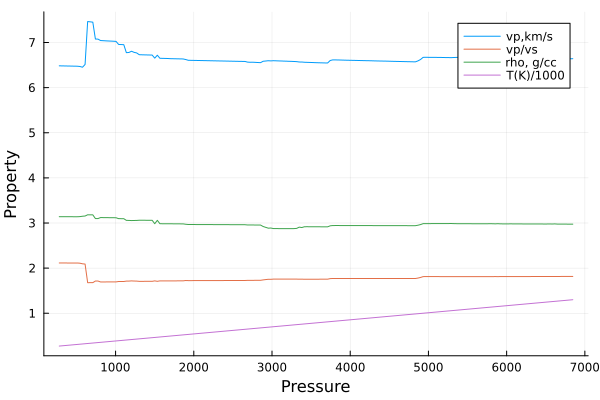

  0.689359 seconds (556.40 k allocations: 27.369 MiB, 0.73% gc time, 16.25% compilation time)


In [20]:
## ---

geotherm = 0.15 # Geothermal gradient, K/bar. For reference, 0.1 K/bar ≈ 28.4 K/km
@time bulk = perplex_query_system(scratchdir, (280, (max_lith_T-273.15)/geotherm), T_range, index=3, npoints=200, include_fluid="n")

h = plot(xlabel="Pressure", ylabel="Property")
plot!(h,bulk["P(bar)"],bulk["vp,km/s"], label="vp,km/s")
plot!(h,bulk["P(bar)"],bulk["vp/vs"], label="vp/vs")
plot!(h,bulk["P(bar)"],bulk["rho,kg/m3"]/1000, label="rho, g/cc")
plot!(h,bulk["P(bar)"],bulk["T(K)"]/1000, label="T(K)/1000")
# savefig(h,"GeothermSeismicProperties.pdf")
display(h)